# EDA with ETNA (geospatial data)

## Andrey Alekseev

## Data description:
.csv file hold sample data for ride sharing app. 

Data consists of the following columns:
```
start_time - time when the order was made
start_lat - latitude of the location where the order was made
start_lng - longitude of the location where the order was made
end_lat - latitude of the destination point
end_lng - longitude of the destination point
ride_value - how much monetary value is in this particular ride
```

## EDA purpose description:

Availability of supply depends on the duration of time it takes for the drivers to reach the customers. It makes sense to attract drivers towards areas of highest anticipation and highest ride value. 

Check if it is possible to predict areas of high ride value using only the data available. 

## Summary of EDA:

- Filtered outliers based on geolocation;
- Clustered data based on geolocation;
- Rearranded data into 30 minutes intervals using the geolocation of the starting coordinates;
- Tried several models to predict results;

# EDA
## Load and validate the data
First, let's load the data and look at it.

The source data is 627210 rows of synthetic ride demand data which resembles the real-life situation in the city of Tallinn. The data seems to be only March 2022. Also there are no NaNs in the data. However maximum value of 3172 in ride_value column makes me think that it is outlier. I also can see geolocation as other source of outliers. I will check it later.

Also I will round start time to half hour intervals. It seems reasonable, since rounding to 15 minutes intervals could require us to collect more data (off peak hours especially) and 1 hour interval could be too general to predict demand in the area. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import seaborn as sns
import datetime
import matplotlib.pyplot as plt

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('../data/ride_data.csv')
df.head(10)

start_time  start_lat  start_lng    end_lat    end_lng  \
0  2022-03-06 15:02:39.329452000  59.407910  24.689836  59.513027  24.831630   
1  2022-03-10 11:15:55.177526000  59.441650  24.762712  59.426450  24.783076   
2  2022-03-06 14:23:33.893257000  59.435404  24.749795  59.431901  24.761588   
3  2022-03-03 09:11:59.104192000  59.406920  24.659006  59.381093  24.641652   
4  2022-03-06 00:13:01.290346000  59.434940  24.753641  59.489203  24.876170   
5  2022-03-02 07:17:34.858783000  59.433606  24.712736  59.435205  24.748843   
6  2022-03-17 11:08:25.117959000  59.398960  24.710864  59.440976  24.760222   
7  2022-03-18 14:34:56.333676000  59.416808  24.799002  59.406496  24.683917   
8  2022-03-13 19:19:32.659761000  59.432321  24.760523  59.423296  24.749209   
9  2022-03-17 16:20:20.028387000  59.410783  24.721219  59.439901  24.771756   

   ride_value  
0     3.51825  
1     0.50750  
2     0.19025  
3     0.75600  
4     2.27100  
5     0.50275  
6     1.35200  
7     1.62200  
8     0.29550  
9     1.06975

In [3]:
df.describe()

start_lat      start_lng        end_lat        end_lng  \
count  627210.000000  627210.000000  627210.000000  627210.000000   
mean       59.428682      24.743468      59.397797      24.724847   
std         0.021764       0.056872       1.392755       1.650709   
min        59.321557      24.505199     -37.819979    -122.453962   
25%        59.418803      24.713140      59.415215      24.707919   
50%        59.432069      24.744674      59.430697      24.744335   
75%        59.439024      24.768115      59.439262      24.773924   
max        59.566998      24.973743      61.552744     144.966110   

          ride_value  
count  627210.000000  
mean        2.261384  
std        44.889892  
min         0.107628  
25%         0.545250  
50%         1.059000  
75%         1.712000  
max      3172.701000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


In [5]:
df["start_time"] = pd.to_datetime(df["start_time"])
print(f"Dataset's min timestamp: {df.start_time.min()}; Max timestamp: {df.start_time.max()}")

Dataset's min timestamp: 2022-03-01 00:00:07.936317; Max timestamp: 2022-03-28 23:59:53.175658


In [6]:
df['timestamp'] = df['start_time'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, 
                                                                      30*(dt.minute // 30)))
df.head()

start_time  start_lat  start_lng    end_lat    end_lng  \
0 2022-03-06 15:02:39.329452  59.407910  24.689836  59.513027  24.831630   
1 2022-03-10 11:15:55.177526  59.441650  24.762712  59.426450  24.783076   
2 2022-03-06 14:23:33.893257  59.435404  24.749795  59.431901  24.761588   
3 2022-03-03 09:11:59.104192  59.406920  24.659006  59.381093  24.641652   
4 2022-03-06 00:13:01.290346  59.434940  24.753641  59.489203  24.876170   

   ride_value           timestamp  
0     3.51825 2022-03-06 15:00:00  
1     0.50750 2022-03-10 11:00:00  
2     0.19025 2022-03-06 14:00:00  
3     0.75600 2022-03-03 09:00:00  
4     2.27100 2022-03-06 00:00:00

## Outliers

As I said earlier I want to deal with outliers for `ride_value` column and geolocation columns.

For `ride_value` I delete everything that lying beyond 99th quantile. 

For geolocation columns I will check whenever the point (either starting or ending) is part of the sea. All the sea points should be deleted.

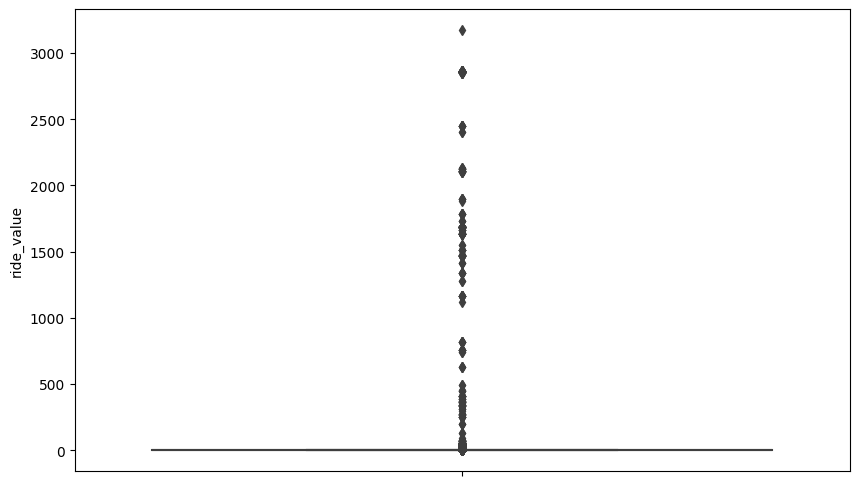

In [7]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(y="ride_value", data = df)

In [8]:
df = df[df.ride_value <= df.ride_value.quantile(0.99)]

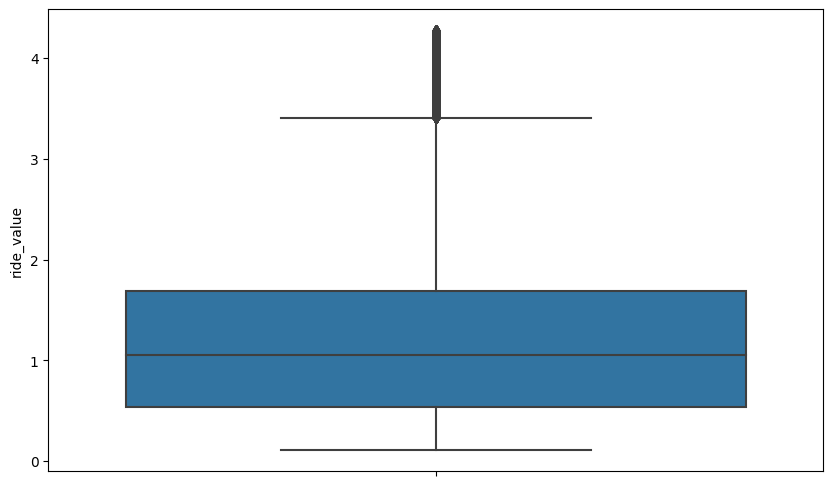

In [9]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(y="ride_value", data = df)

In [10]:
from global_land_mask import globe

df["is_sea"] = df.parallel_apply(lambda x: globe.is_ocean(x["start_lat"], x["start_lng"]) or globe.is_ocean(x["end_lat"], x["end_lng"]), axis=1)
df["is_sea"].value_counts()

False    617137
True       3803
Name: is_sea, dtype: int64

In [11]:
df = df[~df['is_sea']]
df = df.drop(columns=["is_sea"])

## Geolocation clustering

I want to aggreate data into clusters, since I want to predict demand based on the location. This could be done in several ways:
1. Uber h3.
2. Clustering algorithms.
3. Handmade distict boundaries.

I will try first two approaches, since the idea is to check out if idea is valuable and not to create the best possible solution. I will summarize ride_values based on time and cluster, because I want to predict overall demand in the locations. To choose the best clustering algorithm I will use Prophet model, because this model seems to be a good baseline for time series forecasting problems. 

To conduct forecasting task I will use ETNA library that allows me easily create pipeline to handle forecasting for several clusters and also apply time series cross validation techniques to my dataset automatically calculating metrics for each cluster.

In [12]:
import folium
import h3
from etna.datasets import TSDataset
from etna.transforms import TimeSeriesImputerTransform
from etna.models import ProphetModel
from etna.pipeline import Pipeline
from etna.metrics import SMAPE, MAE

from src.EDA.metric_calculation import compare_commulative_metric

tallinn_center =  (59.437425 , 24.745137)
pick_up_map = folium.Map(location=tallinn_center, zoom_start=12)

locationlist = df[["start_lat", "start_lng"]].values.tolist()
for point in range(0, len(locationlist), 1000):
    folium.Marker(locationlist[point]).add_to(pick_up_map)

pick_up_map

### Uber H3
Uber H3 is method and open source library introduced by Uber that is useful for analyzing large spatial data sets, partitioning areas of the Earth into hierarchial hexagon grid cells. Uber uses it for optimizing ride pricing and dispatch, visualizing and exploring spatial datasets. The purpose of the library perfectly fits my task. So I give it a go!

In [13]:
df_h3 = df.copy()
df_h3['h6'] = df_h3.parallel_apply(lambda x : h3.geo_to_h3(x.start_lat, x.start_lng, 6), axis = 1)
df_h3.head()

start_time  start_lat  start_lng    end_lat    end_lng  \
0 2022-03-06 15:02:39.329452  59.407910  24.689836  59.513027  24.831630   
1 2022-03-10 11:15:55.177526  59.441650  24.762712  59.426450  24.783076   
2 2022-03-06 14:23:33.893257  59.435404  24.749795  59.431901  24.761588   
3 2022-03-03 09:11:59.104192  59.406920  24.659006  59.381093  24.641652   
4 2022-03-06 00:13:01.290346  59.434940  24.753641  59.489203  24.876170   

   ride_value           timestamp               h6  
0     3.51825 2022-03-06 15:00:00  86089bc5fffffff  
1     0.50750 2022-03-10 11:00:00  86089b1a7ffffff  
2     0.19025 2022-03-06 14:00:00  86089b1a7ffffff  
3     0.75600 2022-03-03 09:00:00  86089bc5fffffff  
4     2.27100 2022-03-06 00:00:00  86089b1a7ffffff

Then summarize ride_value per 30 minutes interval in respect to the cluster.
To use ETNA library I have to do some adjustments to column names.

In [14]:
df_h3 = df_h3[["h6", 'ride_value', 'timestamp']].groupby(["h6", 'timestamp']).sum().reset_index()
df_etna_h3 = df_h3.rename(columns={"h6": "segment", "ride_value": "target"})
df_etna_h3.head()

segment           timestamp   target
0  86089b017ffffff 2022-03-01 07:30:00  3.28600
1  86089b017ffffff 2022-03-03 11:00:00  3.01675
2  86089b017ffffff 2022-03-04 20:00:00  2.99350
3  86089b017ffffff 2022-03-06 22:00:00  2.82150
4  86089b017ffffff 2022-03-07 20:00:00  4.08900

In [15]:
ts = TSDataset(TSDataset.to_dataset(df_etna_h3), freq="30T")
imputer = TimeSeriesImputerTransform(strategy="forward_fill")
ts.fit_transform([imputer])
ts = TSDataset(ts.to_pandas(), freq="30T")
ts.head()

segment             86089b017ffffff 86089b037ffffff 86089b0a7ffffff  \
feature                      target          target          target   
timestamp                                                             
2022-03-01 00:00:00             NaN          2.8855             NaN   
2022-03-01 00:30:00             NaN          6.8010             NaN   
2022-03-01 01:00:00             NaN          6.8010             NaN   
2022-03-01 01:30:00             NaN          6.8010             NaN   
2022-03-01 02:00:00             NaN          6.8010             NaN   

segment             86089b11fffffff 86089b187ffffff 86089b18fffffff  \
feature                      target          target          target   
timestamp                                                             
2022-03-01 00:00:00             NaN        20.13300         11.0530   
2022-03-01 00:30:00             NaN        30.70725         10.8285   
2022-03-01 01:00:00             NaN        15.06550          3.3355   
2022-03-01 01:30:00             NaN        12.98850          3.6520   
2022-03-01 02:00:00             NaN        17.92625          3.8600   

segment             86089b197ffffff 86089b19fffffff 86089b1a7ffffff  \
feature                      target          target          target   
timestamp                                                             
2022-03-01 00:00:00             NaN          4.0545       181.14700   
2022-03-01 00:30:00         1.47125          2.0225       155.81000   
2022-03-01 01:00:00         1.47125          2.0225       194.27200   
2022-03-01 01:30:00         5.25250          3.6040       149.20050   
2022-03-01 02:00:00         1.46875          2.5040       131.87875   

segment             86089b1afffffff  ... 86089bc47ffffff 86089bc4fffffff  \
feature                      target  ...          target          target   
timestamp                            ...                                   
2022-03-01 00:00:00         6.56075  ...        10.23375             NaN   
2022-03-01 00:30:00         5.77200  ...         6.30725         3.71025   
2022-03-01 01:00:00         5.84650  ...         6.56725         3.71025   
2022-03-01 01:30:00         6.05425  ...         8.37950         9.15875   
2022-03-01 02:00:00         5.93900  ...         8.37950         1.40150   

segment             86089bc57ffffff 86089bc5fffffff 86089bc67ffffff  \
feature                      target          target          target   
timestamp                                                             
2022-03-01 00:00:00         4.68950        60.87350             NaN   
2022-03-01 00:30:00         4.84650        41.55050             NaN   
2022-03-01 01:00:00         4.65925        35.12425             NaN   
2022-03-01 01:30:00         4.65925        39.33950             NaN   
2022-03-01 02:00:00         8.98300        48.92275             NaN   

segment             86089bc77ffffff 86089bcc7ffffff 86089bccfffffff  \
feature                      target          target          target   
timestamp                                                             
2022-03-01 00:00:00             NaN             NaN             NaN   
2022-03-01 00:30:00             NaN             NaN             NaN   
2022-03-01 01:00:00             NaN             NaN         1.88375   
2022-03-01 01:30:00             NaN             NaN         1.88375   
2022-03-01 02:00:00             NaN             NaN         1.88375   

segment             86089bce7ffffff 86089bcefffffff  
feature                      target          target  
timestamp                                            
2022-03-01 00:00:00             NaN           4.930  
2022-03-01 00:30:00             NaN          14.352  
2022-03-01 01:00:00             NaN          10.218  
2022-03-01 01:30:00             NaN           1.906  
2022-03-01 02:00:00             NaN           5.441  

[5 rows x 22 columns]

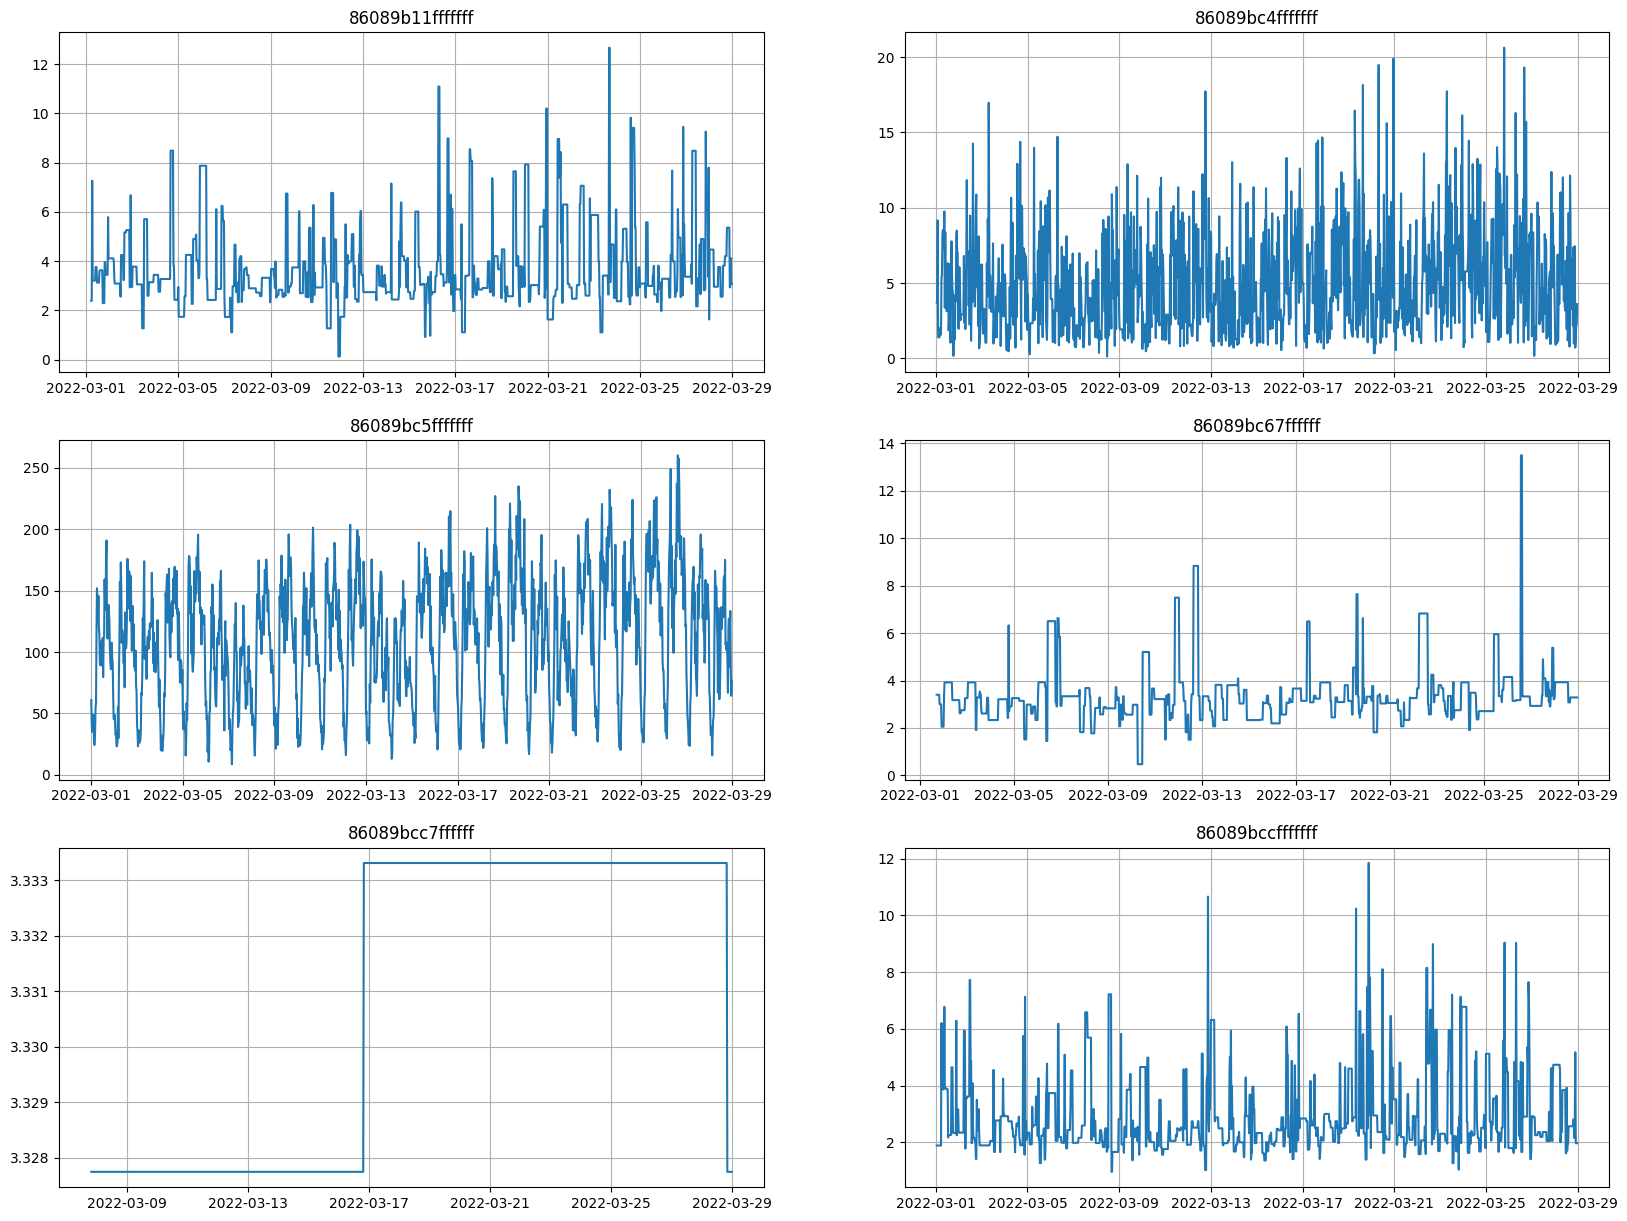

In [18]:
ts.plot(n_segments=6)

Some clusters are really small and have almost no data, however I will continue the experiment.

I will use Prophet model to predict clusters 7 days in advance. Then I will sum the prediction and compare real values and predicted values.

In [19]:
# This will silence excessive Prophet logging
import logging
import sys
logging.disable(sys.maxsize)


prophet_model = ProphetModel(n_changepoints=3, yearly_seasonality=False, weekly_seasonality=True, 
                             daily_seasonality=True)
pipe = Pipeline(model=prophet_model, horizon=48)
prophet_result = pipe.backtest(ts, metrics=[SMAPE(), MAE()], n_folds=7, n_jobs=8)

[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   30.5s
[Parallel(n_jobs=8)]: Done   2 out of   7 | elapsed:   31.2s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:   32.3s remaining:   43.1s
[Parallel(n_jobs=8)]: Done   4 out of   7 | elapsed:   33.4s remaining:   25.0s
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:   33.5s remaining:   13.4s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:   34.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:   34.8s finished


In [20]:
compare_commulative_metric(ts, prophet_result[1], SMAPE())

{'SUMMARIZATION_OF_ALL_SEGMENTS_METRIC_SMAPE': 14.23919961570212}

In [21]:
compare_commulative_metric(ts, prophet_result[1], MAE())

{'SUMMARIZATION_OF_ALL_SEGMENTS_METRIC_MAE': 86.03542638894338}

### Clustering
For clustering I will use simple KMeans model just to validate results from Uber H3 algorithm.

In [22]:
from sklearn.cluster import MiniBatchKMeans

In [23]:
coord = df[df["timestamp"] < "2022-03-22 00:00:00"][['start_lat', 'start_lng']].values
regions = MiniBatchKMeans(n_clusters = 10, batch_size = 10000).fit(coord)

In [24]:
df_cl = df.copy()
df_cl["region"] = regions.predict(df_cl[['start_lat', 'start_lng']].values)
df_cl.head()

start_time  start_lat  start_lng    end_lat    end_lng  \
0 2022-03-06 15:02:39.329452  59.407910  24.689836  59.513027  24.831630   
1 2022-03-10 11:15:55.177526  59.441650  24.762712  59.426450  24.783076   
2 2022-03-06 14:23:33.893257  59.435404  24.749795  59.431901  24.761588   
3 2022-03-03 09:11:59.104192  59.406920  24.659006  59.381093  24.641652   
4 2022-03-06 00:13:01.290346  59.434940  24.753641  59.489203  24.876170   

   ride_value           timestamp  region  
0     3.51825 2022-03-06 15:00:00       4  
1     0.50750 2022-03-10 11:00:00       8  
2     0.19025 2022-03-06 14:00:00       1  
3     0.75600 2022-03-03 09:00:00       0  
4     2.27100 2022-03-06 00:00:00       1

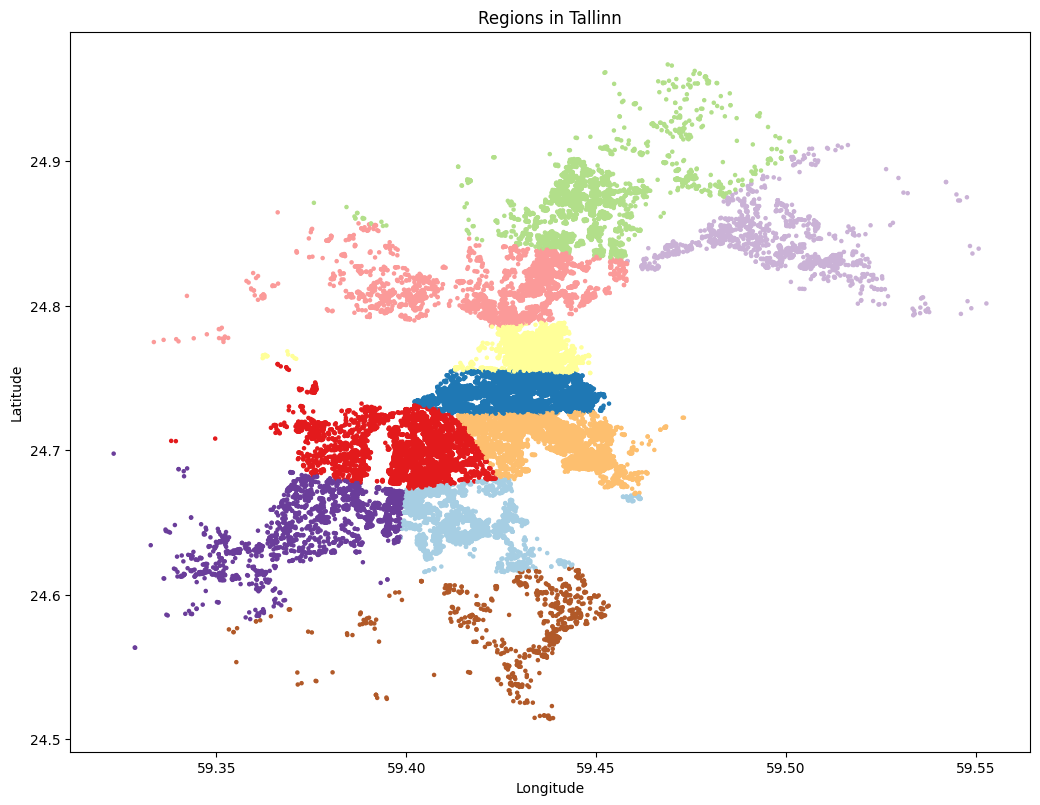

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = df_cl.start_lat.values[:70000], y = df_cl.start_lng.values[:70000], c = df_cl.region.values[:70000], cmap = "Paired", s = 5)
ax.set_title("Regions in Tallinn")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [26]:
df_cl = df_cl[["region", 'ride_value', 'timestamp']].groupby(["region", 'timestamp']).sum().reset_index()
df_etna_cl = df_cl.rename(columns={"region": "segment", "ride_value": "target"})
ts = TSDataset(TSDataset.to_dataset(df_etna_cl), freq="30T")
imputer = TimeSeriesImputerTransform(strategy="forward_fill")
ts.fit_transform([imputer])
ts = TSDataset(ts.to_pandas(), freq="30T")
ts.head()

segment                     0          1         2         3         4  \
feature                target     target    target    target    target   
timestamp                                                                
2022-03-01 00:00:00  20.43325  144.28675  21.52550  11.83325  30.60900   
2022-03-01 00:30:00  24.90100  135.43125  23.90750  20.37725  21.08050   
2022-03-01 01:00:00  17.48650  146.70425   4.81400  12.60325  26.26200   
2022-03-01 01:30:00  20.97625  128.78425  10.15150  13.35175   7.60100   
2022-03-01 02:00:00  20.67825  106.57450   9.96525  12.78625  22.35175   

segment                     5         6         7         8        9  
feature                target    target    target    target   target  
timestamp                                                             
2022-03-01 00:00:00  28.19375   9.44625  23.18425  39.22275  6.45025  
2022-03-01 00:30:00  17.35300  14.97300  14.76900  27.27825  6.30725  
2022-03-01 01:00:00  19.41650   9.04700  11.31275  40.32875  5.39925  
2022-03-01 01:30:00  28.40950   6.05425   8.46600  28.66325  6.70000  
2022-03-01 02:00:00  23.42850   8.12750  16.75150  17.77500  6.70000

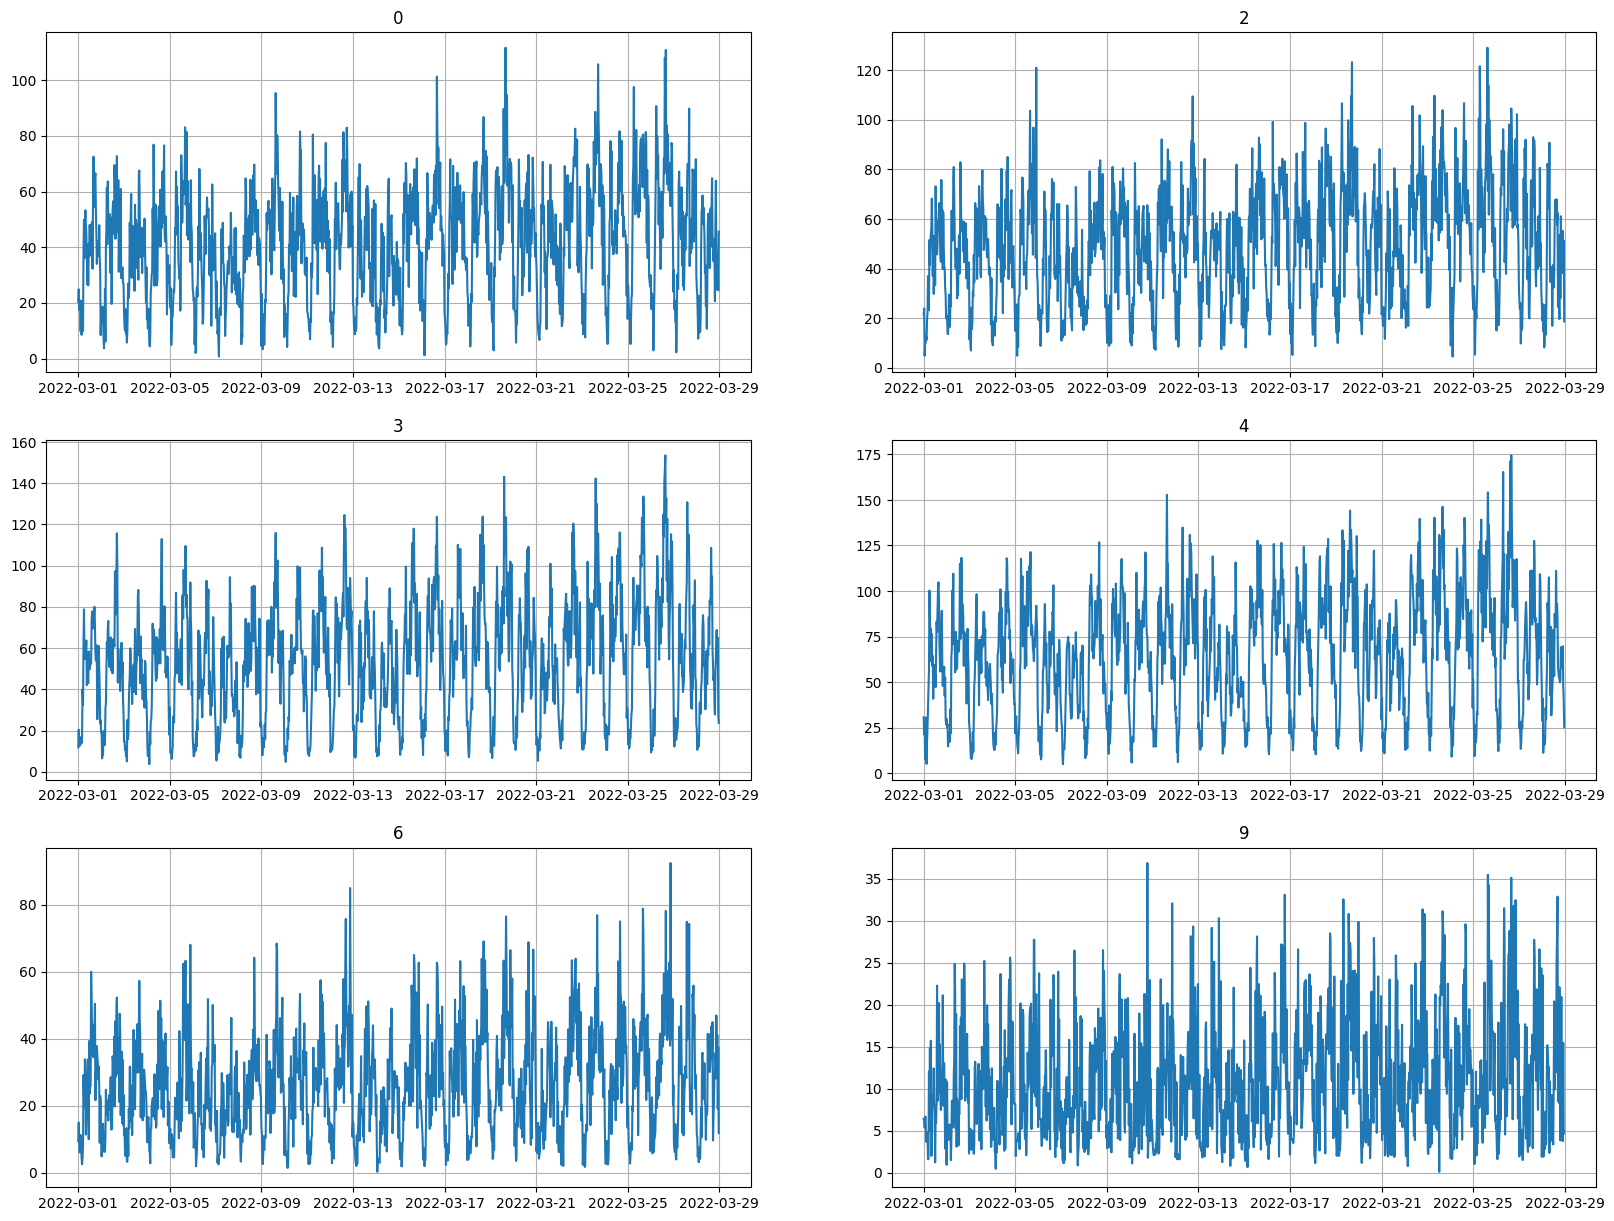

In [27]:
ts.plot(n_segments=6)

I must admit, that clusters from KMeans look better in terms of quality of time series than Uber H3.

In [28]:
prophet_model = ProphetModel(n_changepoints=3, yearly_seasonality=False, weekly_seasonality=True, 
                             daily_seasonality=True)
pipe = Pipeline(model=prophet_model, horizon=48)
prophet_result_kmeans = pipe.backtest(ts, metrics=[SMAPE(), MAE()], n_folds=7, n_jobs=8)

[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done   2 out of   7 | elapsed:   15.6s remaining:   39.1s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:   15.7s remaining:   21.0s
[Parallel(n_jobs=8)]: Done   4 out of   7 | elapsed:   15.8s remaining:   11.8s
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:   15.8s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:   16.8s finished


In [29]:
compare_commulative_metric(ts, prophet_result_kmeans[1], SMAPE())

{'SUMMARIZATION_OF_ALL_SEGMENTS_METRIC_SMAPE': 15.069297211265972}

In [30]:
compare_commulative_metric(ts, prophet_result_kmeans[1], MAE())

{'SUMMARIZATION_OF_ALL_SEGMENTS_METRIC_MAE': 85.59042015620469}

Turns out that h3 aggregation performs better in terms of SMAPE metric. So I am going to use it for now.

It may happen because we have several locations with high activity (near the city center for example) and the model based on KMeans clusters have managed to predict it well, however failing on rural areas due to the lack of data. This must be researched in the future.

Also I want to plot some additional plots to analise the time series data.

From the plots below I can see that there is no detectable trend in the time series. So we may not take it into account for MVP model. However we should take a look at previous 30 minute lag, yesterday lag and last week lags, because as ACF and PACF plots suggest the ride_value may be impacted by it and it will allow us to make better predictions.

In [31]:
ts = TSDataset(TSDataset.to_dataset(df_etna_h3), freq="30T")
imputer = TimeSeriesImputerTransform(strategy="forward_fill")
ts.fit_transform([imputer])
ts = TSDataset(ts.to_pandas(), freq="30T")

In [32]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, plot_trend

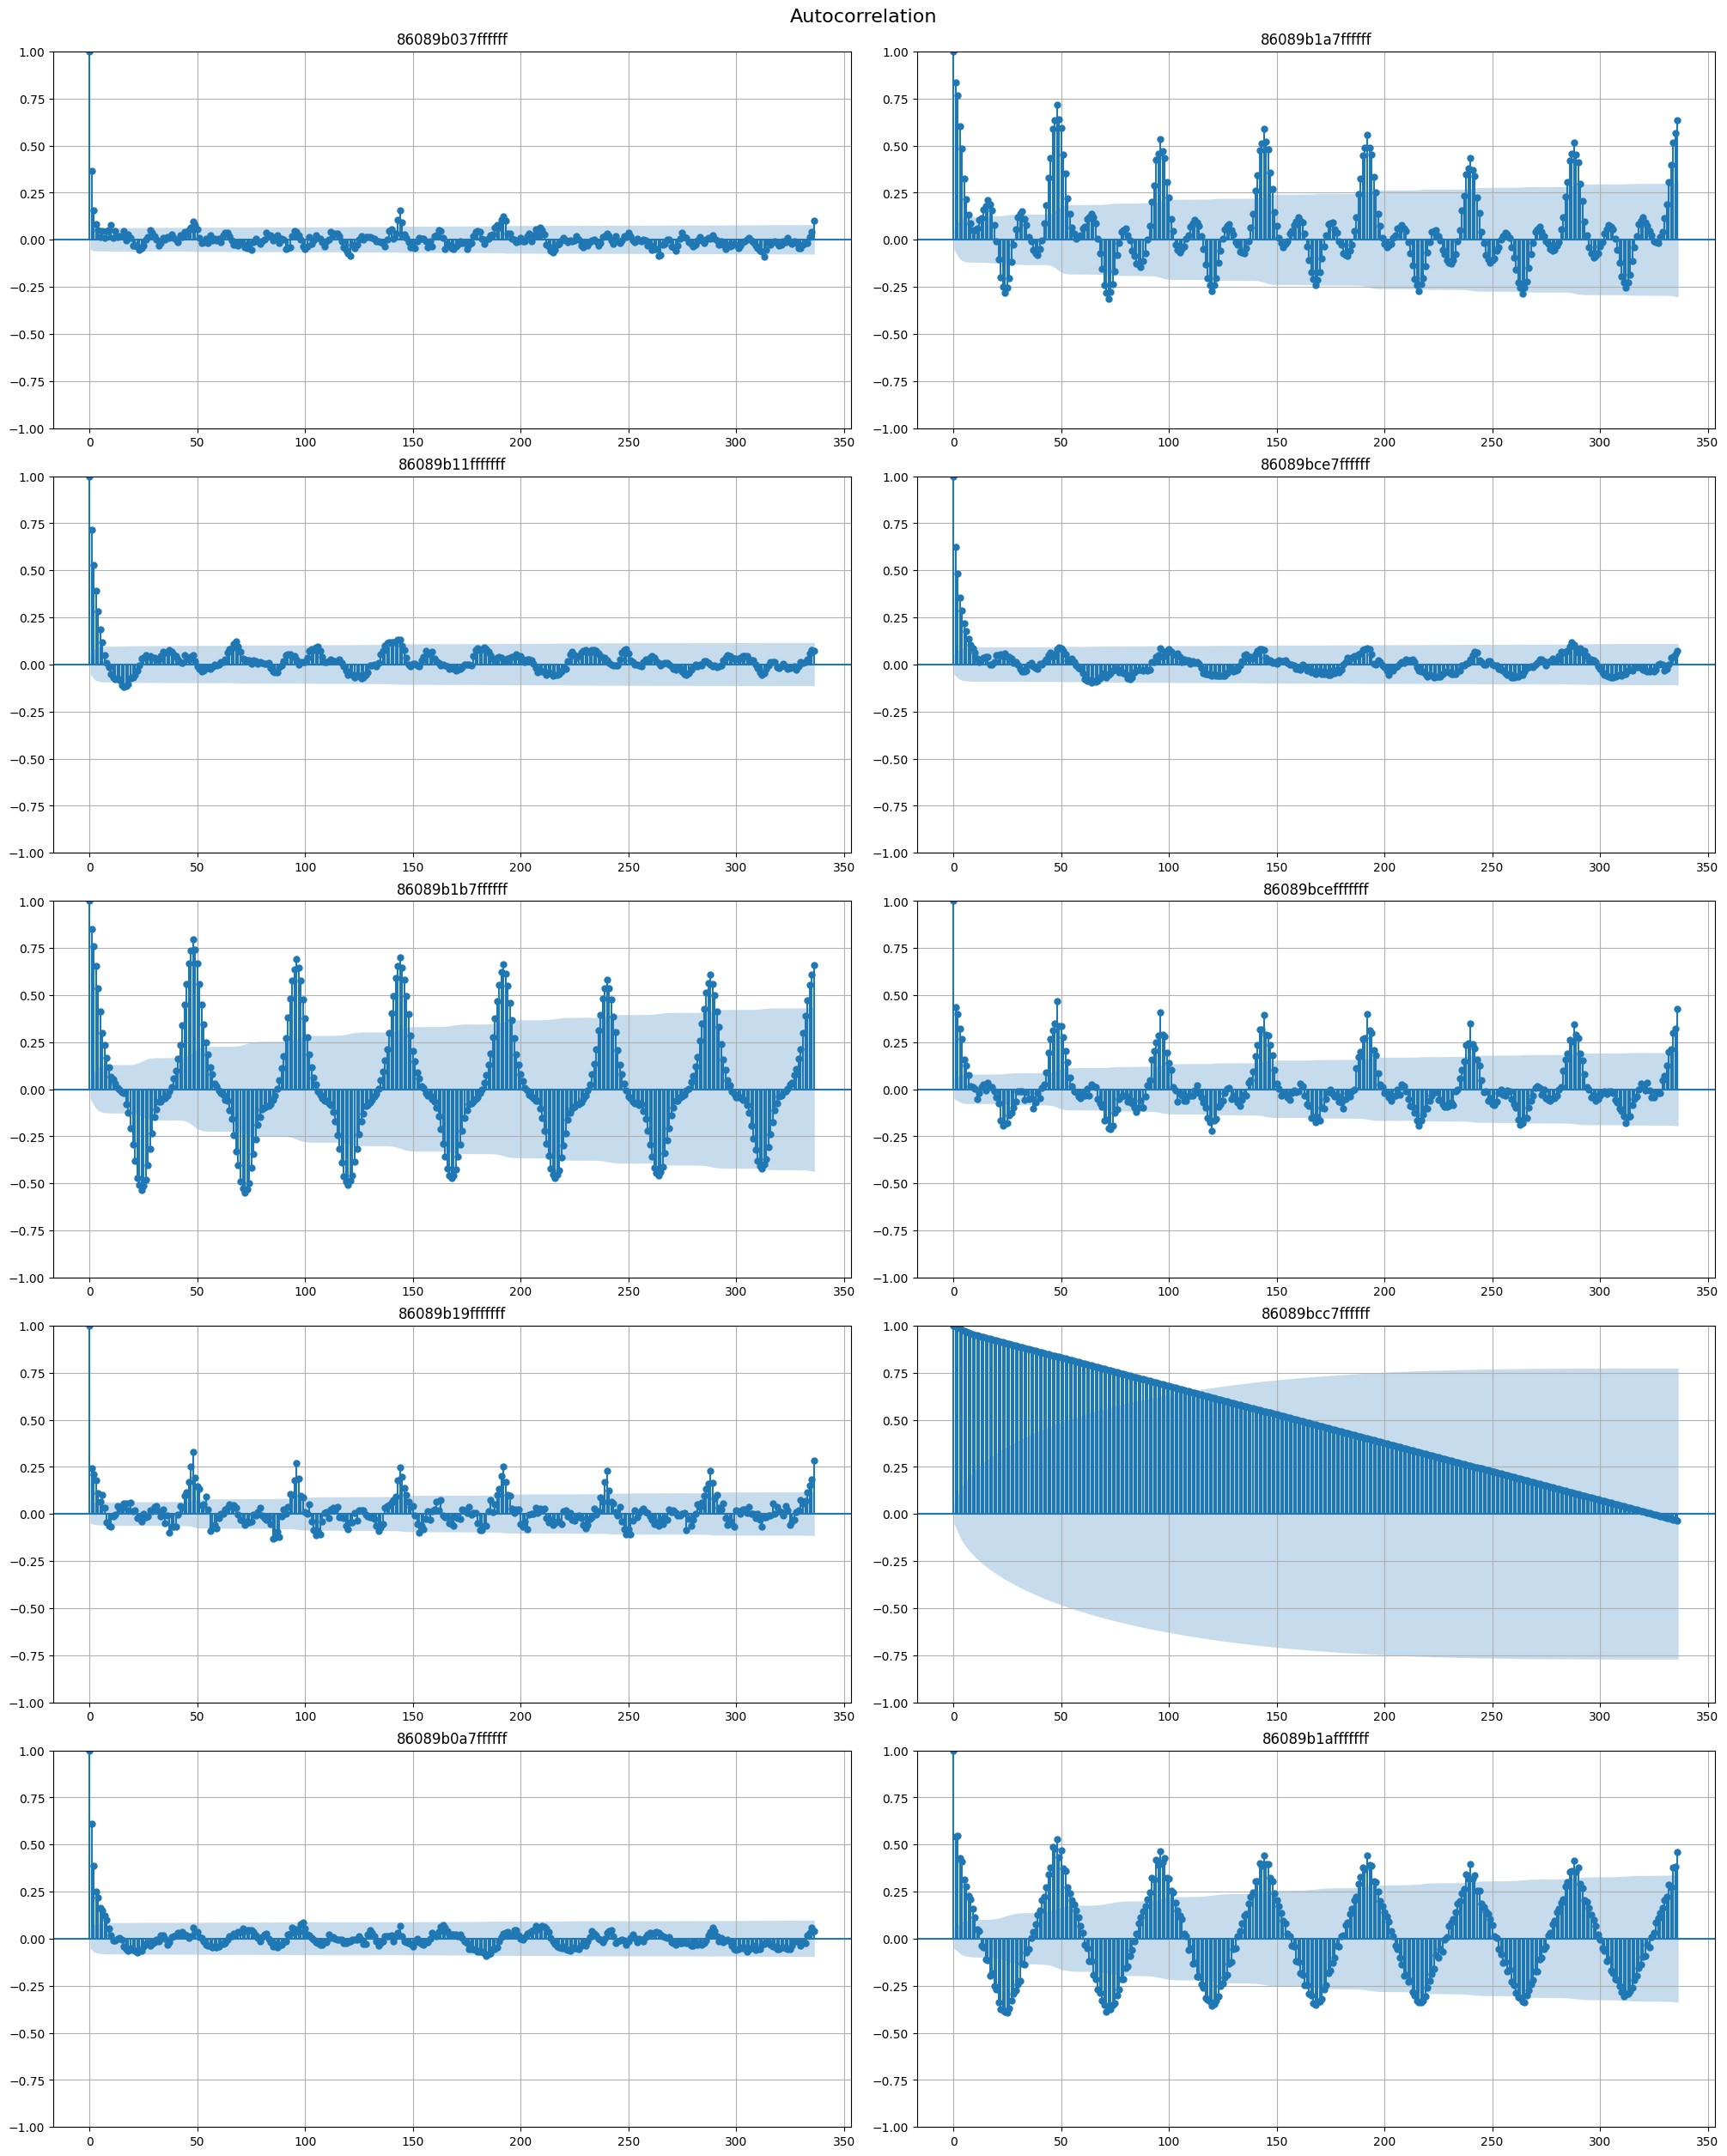

In [33]:
sample_acf_plot(ts, lags=336)

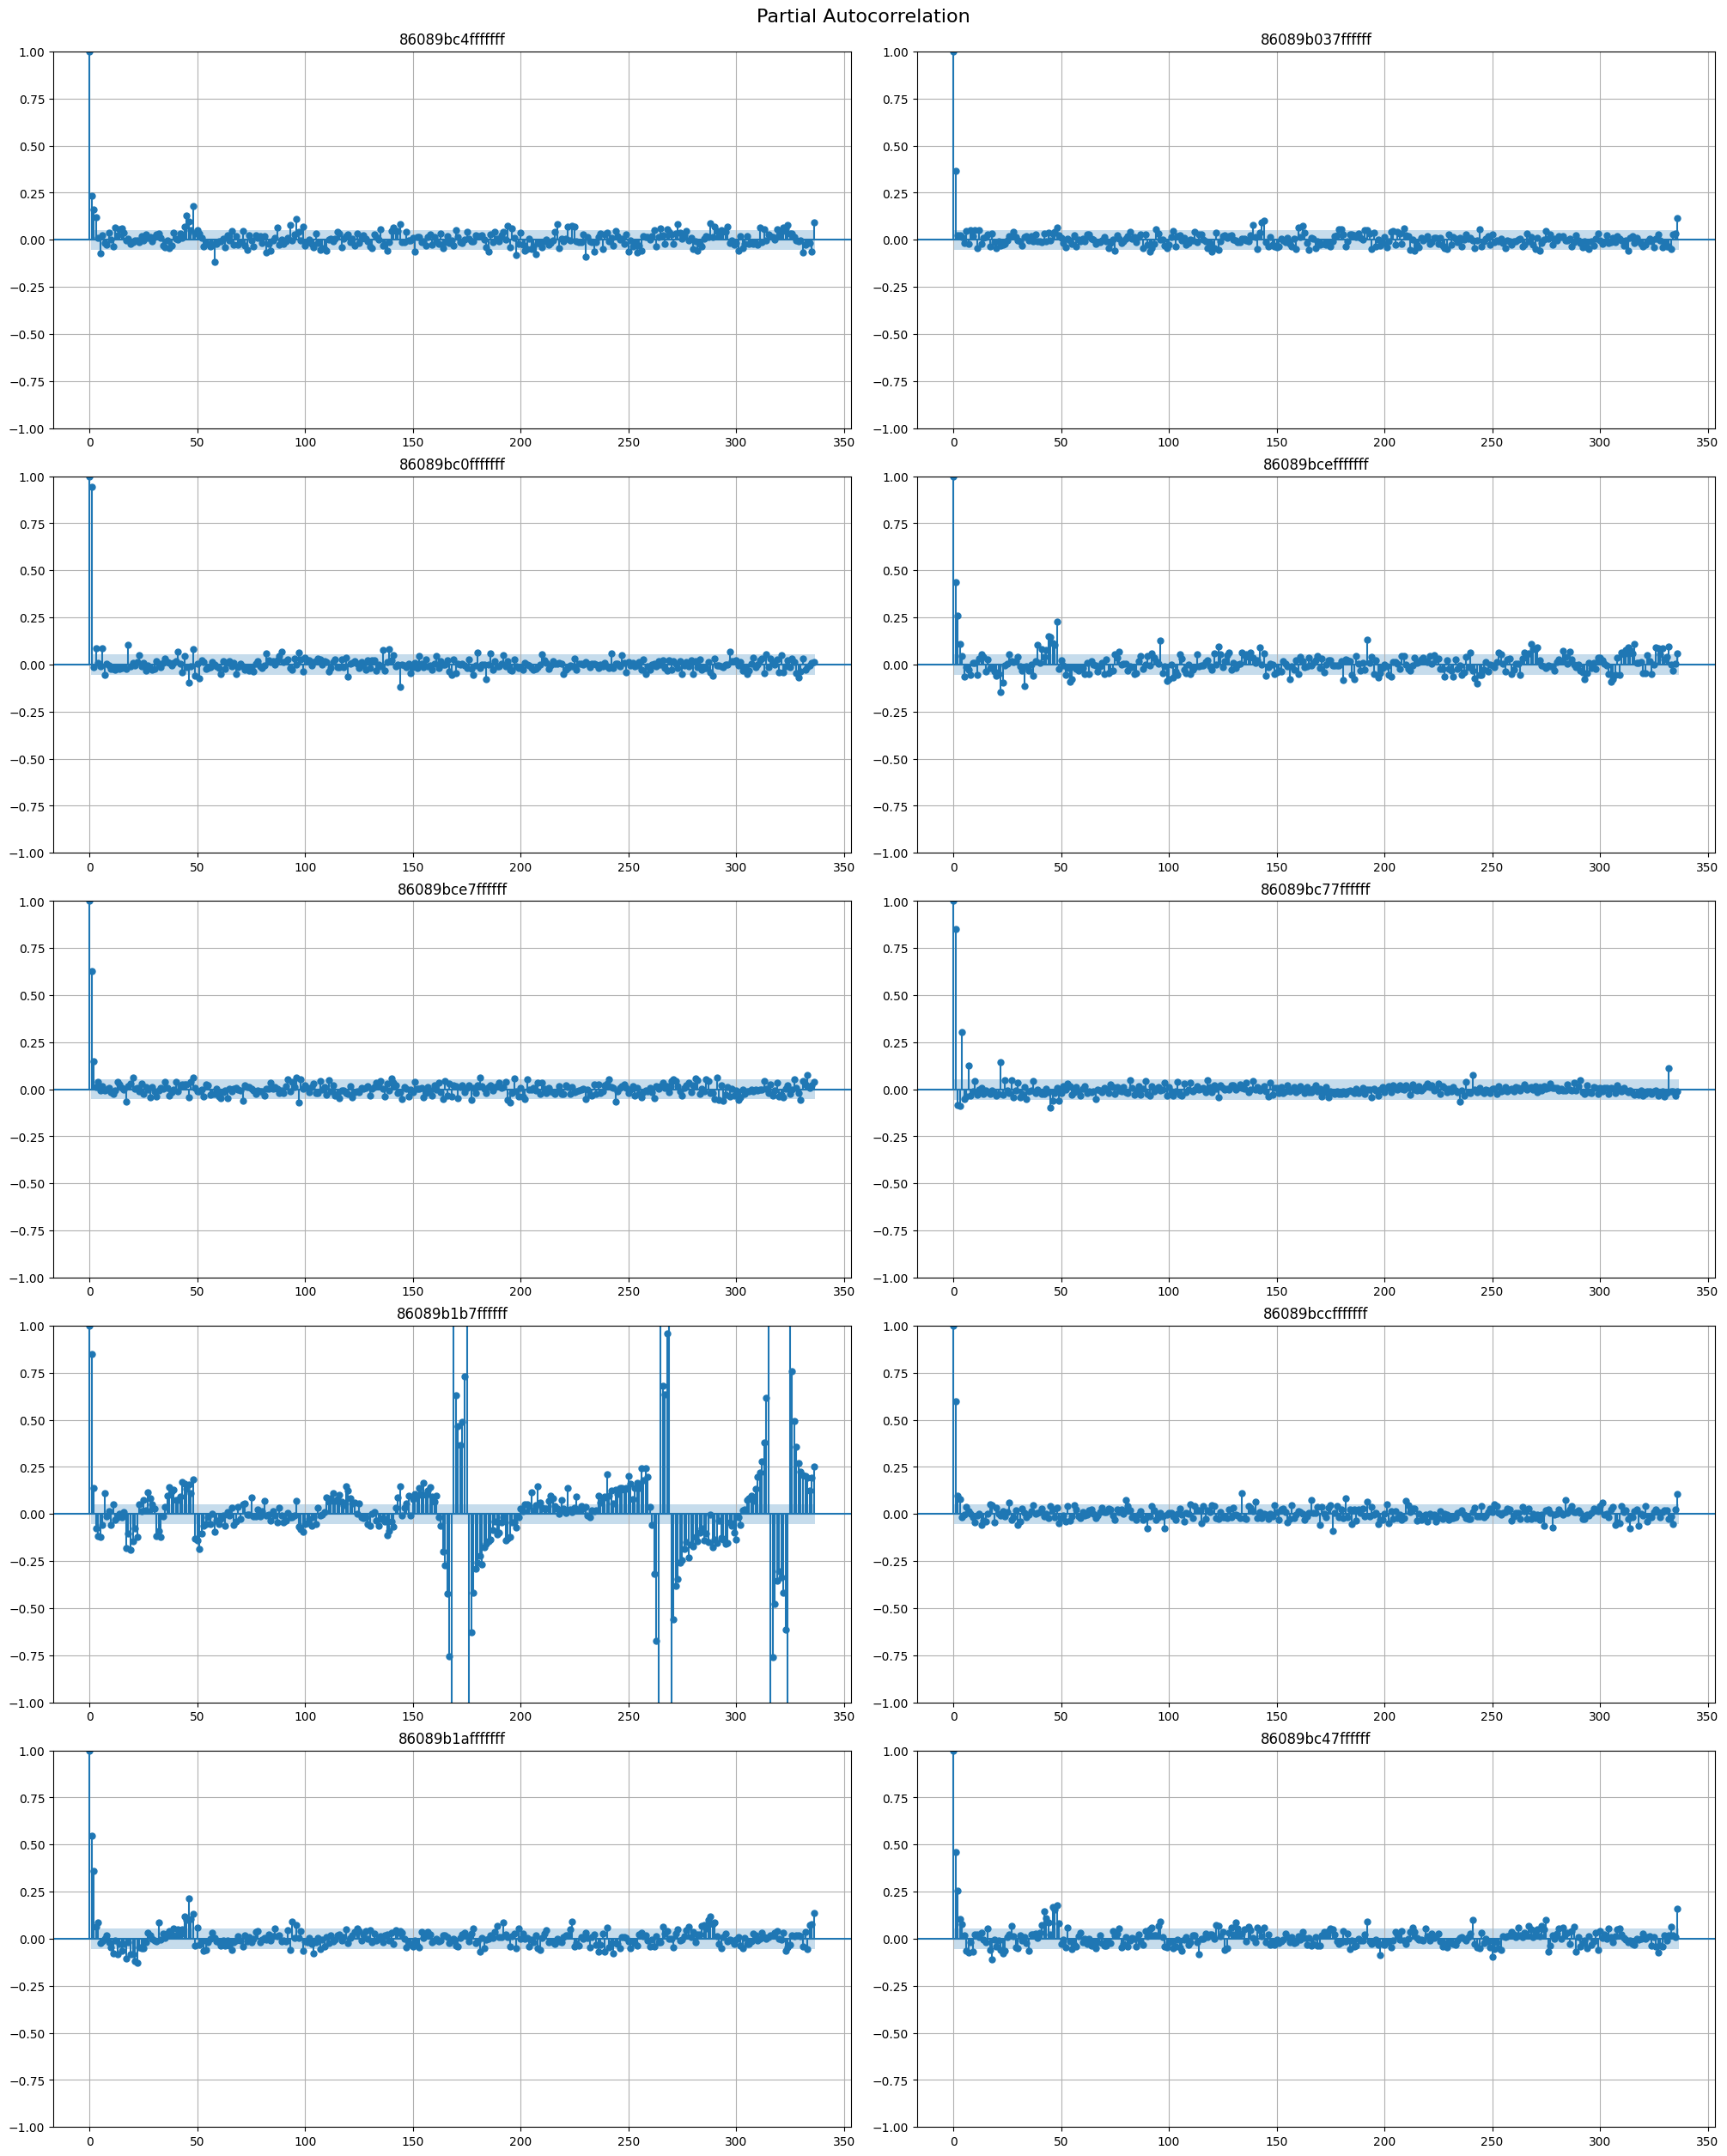

In [34]:
sample_pacf_plot(ts, lags=336)

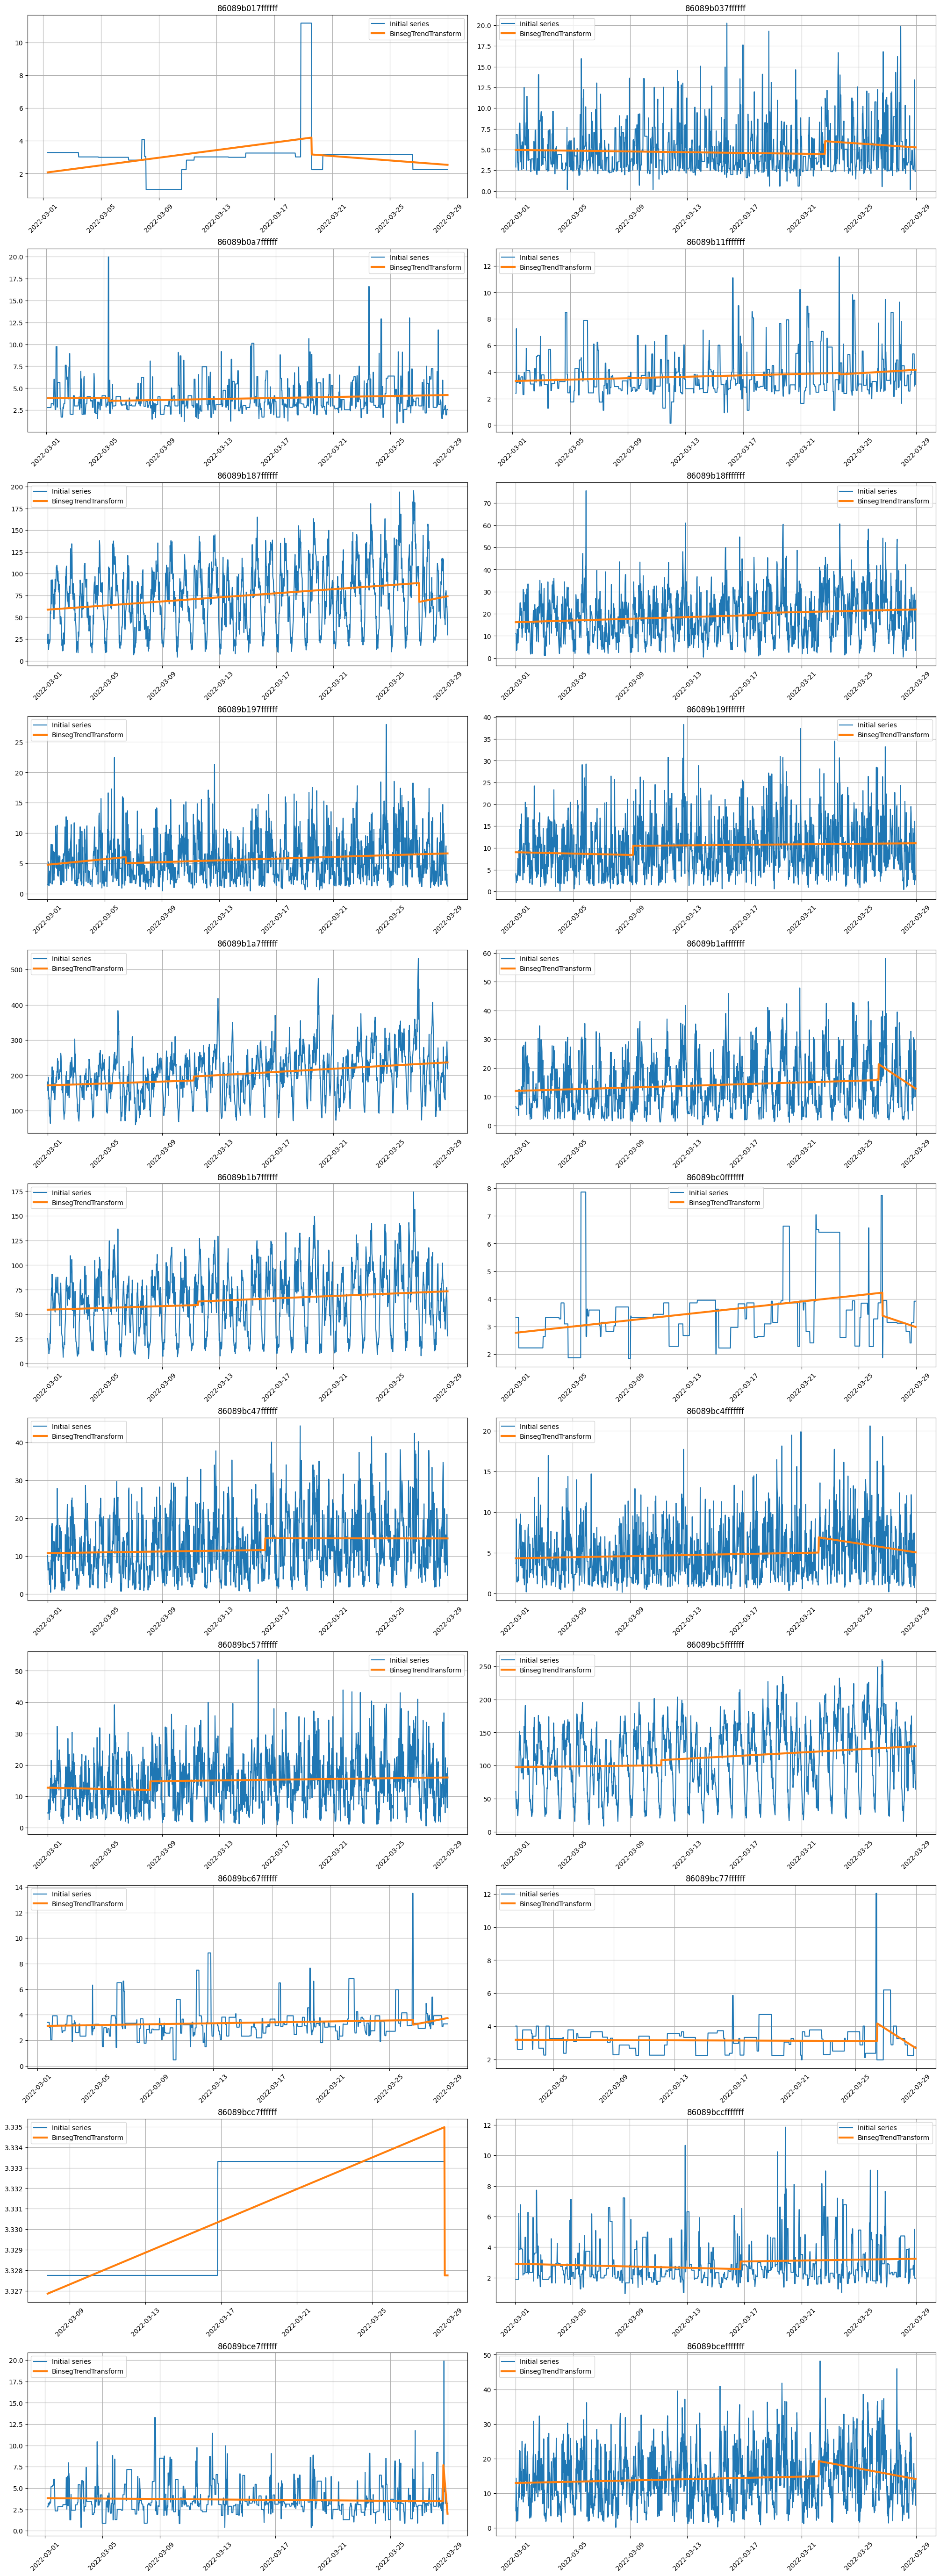

In [35]:
from etna.transforms import BinsegTrendTransform

plot_trend(ts, BinsegTrendTransform(in_column="target", n_bkps=1))

## Forecasting

Since the purpose of this task is to explore the data and possible solutions that we can use later as staring point for developing MVP, I will try two different approaches. The first one is to use ensemble of naive models and the second one is boosting. 

I will predict 1 day in advance (48 point in future). For backtesting period I will use 3 days.

For ensemble creation I will stick to using ETNA library.

In [36]:
from etna.models import HoltWintersModel, NaiveModel, MovingAverageModel, SeasonalMovingAverageModel
from etna.ensembles import VotingEnsemble
from etna.analysis import plot_backtest

sma_7 = Pipeline(model=SeasonalMovingAverageModel(window=7, seasonality=48), horizon=48)
sma_14 = Pipeline(model=SeasonalMovingAverageModel(window=7, seasonality=96), horizon=48)
naive_48 = Pipeline(model=NaiveModel(lag=48), horizon=48)
naive_1w = Pipeline(model=NaiveModel(lag=336), horizon=48)

ens_of_simple_models = VotingEnsemble(weights="auto", pipelines=[naive_48, naive_1w, sma_7, sma_14])

In [37]:
ens_result = ens_of_simple_models.backtest(ts, metrics=[SMAPE(), MAE()], n_folds=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | el

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.5s remainin

In [38]:
ens_result[0].groupby("segment").mean()

SMAPE        MAE  fold_number
segment                                           
86089b017ffffff  33.813586   0.970525          1.0
86089b037ffffff  49.103860   2.790795          1.0
86089b0a7ffffff  31.460554   1.289599          1.0
86089b11fffffff  36.701520   1.595090          1.0
86089b187ffffff  20.120628  15.149692          1.0
86089b18fffffff  37.603014   6.249752          1.0
86089b197ffffff  48.589425   2.667748          1.0
86089b19fffffff  44.781227   4.214347          1.0
86089b1a7ffffff  15.030211  34.563796          1.0
86089b1afffffff  39.390217   5.265139          1.0
86089b1b7ffffff  20.608049  13.004470          1.0
86089bc0fffffff  18.177096   0.684010          1.0
86089bc47ffffff  45.235827   5.796738          1.0
86089bc4fffffff  48.905444   2.208327          1.0
86089bc57ffffff  41.833954   5.889210          1.0
86089bc5fffffff  16.235505  18.983982          1.0
86089bc67ffffff  18.895272   0.757671          1.0
86089bc77ffffff  34.595851   1.292055          1.0
86089bcc7ffffff   0.030783   0.001026          1.0
86089bccfffffff  35.720498   1.117663          1.0
86089bce7ffffff  39.830797   1.471854          1.0
86089bcefffffff  33.754464   4.504488          1.0

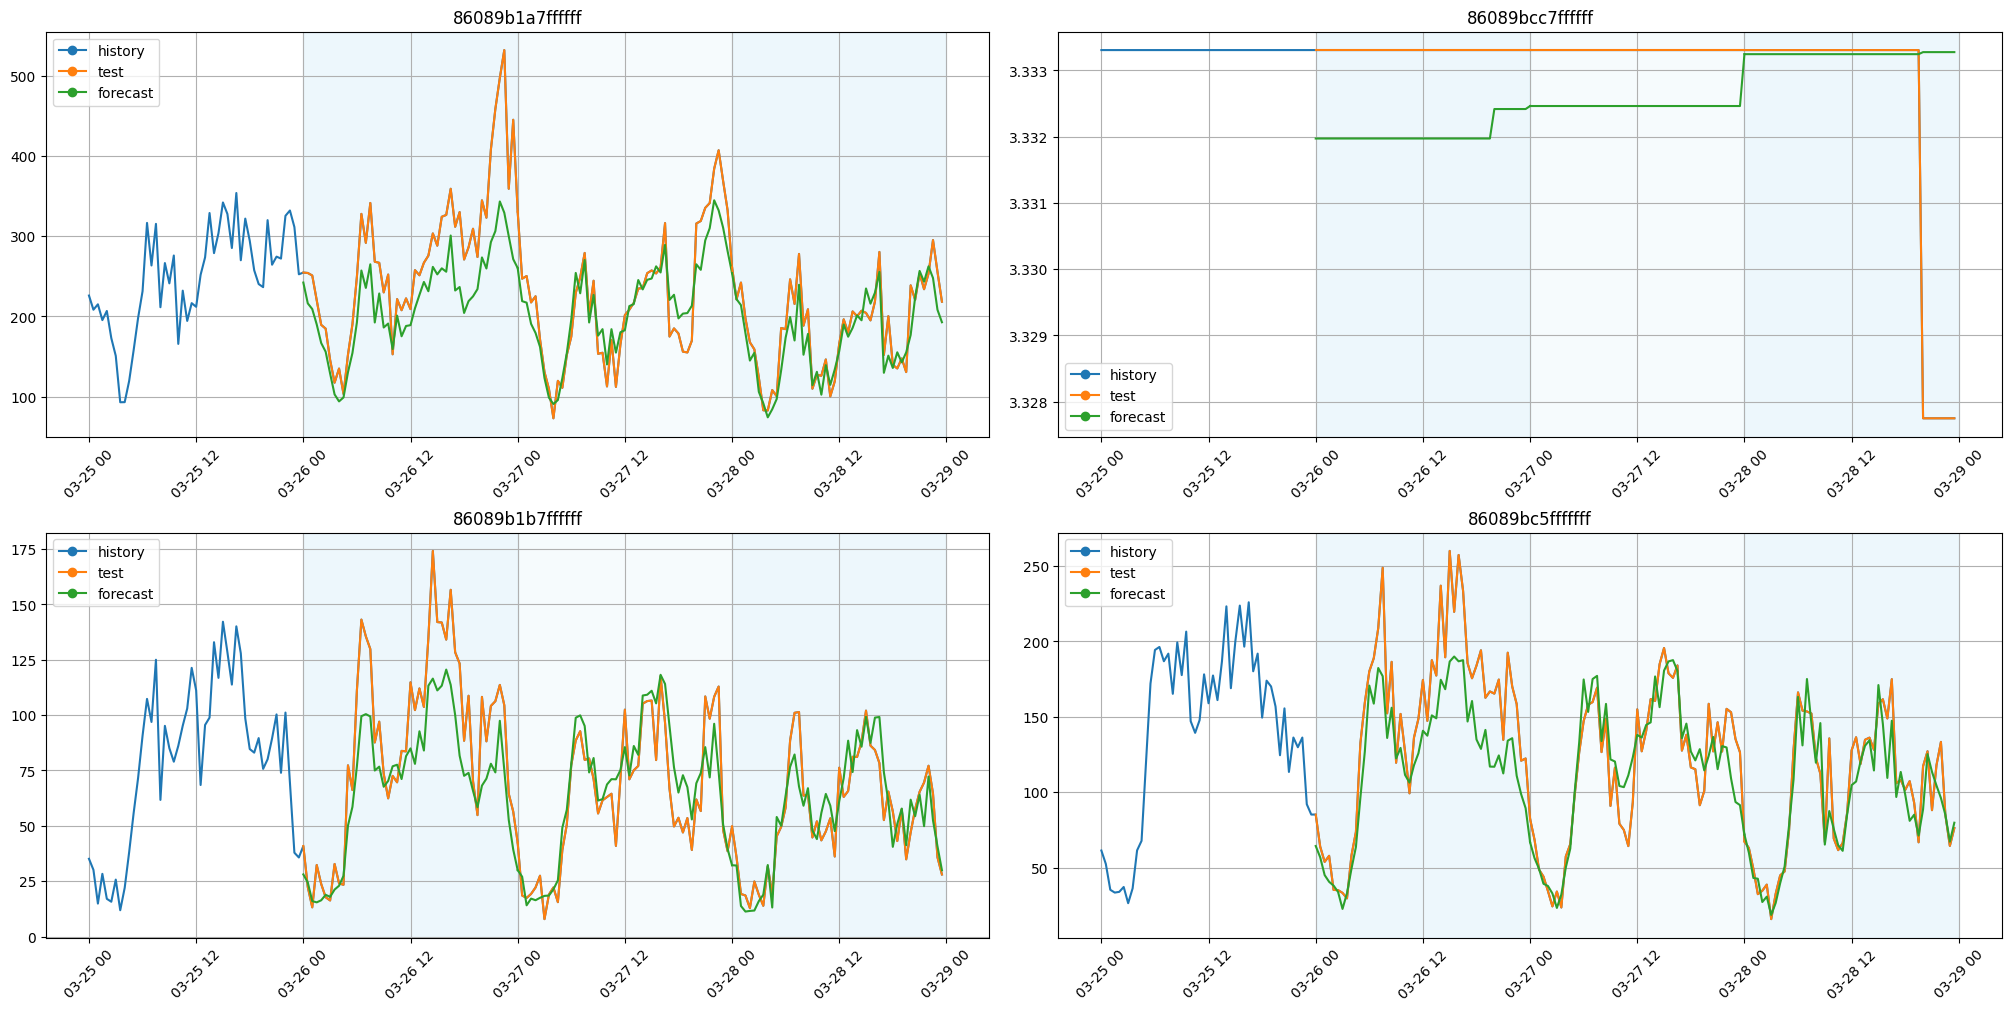

In [48]:
plot_backtest(ens_result[1], ts, history_len=48,
              segments=["86089b1a7ffffff", "86089bcc7ffffff", "86089b1b7ffffff", "86089bc5fffffff"]
             )

As we can see, some time series predicted with plausible results. This applies first of all to big regions.

Now let's try boosing model. As features I use lags from last day, also lags from 1 week ago, statistics, datetime flags, information about holidays and remove linear trend in the data since boosting models unable to extrapolate.

In [41]:
from etna.pipeline import Pipeline
from etna.models import CatBoostModelMultiSegment
from etna.transforms import LagTransform, HolidayTransform, FourierTransform, \
DateFlagsTransform, TimeFlagsTransform, MeanSegmentEncoderTransform, MeanTransform, LinearTrendTransform
from etna.metrics import SMAPE, MAE

In [42]:
model = CatBoostModelMultiSegment()
lag_feat = LagTransform(in_column="target", lags=[i for i in range(48, 96)], out_column="regressor_lag")
lag_1w_feat = LagTransform(in_column="target", lags=[i for i in range(336, 336+48)], out_column="regressor_lag")
fourier_tr = FourierTransform(period=48, mods=[1,2])
mean_seg_tr = MeanSegmentEncoderTransform()
date_tr = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    is_weekend=True,
    special_days_in_week=[4],
)
time_tr = TimeFlagsTransform(
    minute_in_hour_number=False,
    half_hour_number=True,
    half_day_number=True,
    one_third_day_number=True,
)
mean_1d = MeanTransform(in_column="regressor_lag_48", window=48)
mean_same_hour = MeanTransform(in_column="regressor_lag_48", window=7, seasonality=48)
mean_1w = MeanTransform(in_column="regressor_lag_48", window=336)
trend_tr = LinearTrendTransform(in_column="target")
hol_tr = HolidayTransform(iso_code="EE")
pipe = Pipeline(model=model, 
                transforms=[trend_tr, lag_feat, lag_1w_feat, mean_seg_tr, date_tr, 
                            time_tr, mean_1d, mean_1w, hol_tr], 
                horizon=48)

In [43]:
result = pipe.backtest(ts, metrics=[SMAPE(), MAE()], n_folds=3, n_jobs=8)

[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   32.5s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   32.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   32.9s finished


In [44]:
result[0].groupby("segment").mean()

SMAPE        MAE  fold_number
segment                                           
86089b017ffffff  39.625610   1.214494          1.0
86089b037ffffff  48.660527   2.770381          1.0
86089b0a7ffffff  35.758492   1.443947          1.0
86089b11fffffff  26.673381   1.149414          1.0
86089b187ffffff  15.939993  10.876270          1.0
86089b18fffffff  33.813414   6.067335          1.0
86089b197ffffff  45.972694   2.504776          1.0
86089b19fffffff  42.910996   4.123875          1.0
86089b1a7ffffff   9.609055  21.266167          1.0
86089b1afffffff  40.796851   5.572848          1.0
86089b1b7ffffff  17.483943  10.055023          1.0
86089bc0fffffff  17.551292   0.653100          1.0
86089bc47ffffff  41.131065   5.218561          1.0
86089bc4fffffff  49.986134   2.384963          1.0
86089bc57ffffff  39.529560   5.548110          1.0
86089bc5fffffff  12.732261  14.226693          1.0
86089bc67ffffff  16.576003   0.710460          1.0
86089bc77ffffff  30.077257   1.145646          1.0
86089bcc7ffffff   7.629526   0.255002          1.0
86089bccfffffff  34.618795   1.076633          1.0
86089bce7ffffff  31.982736   1.280336          1.0
86089bcefffffff  32.944371   4.606613          1.0

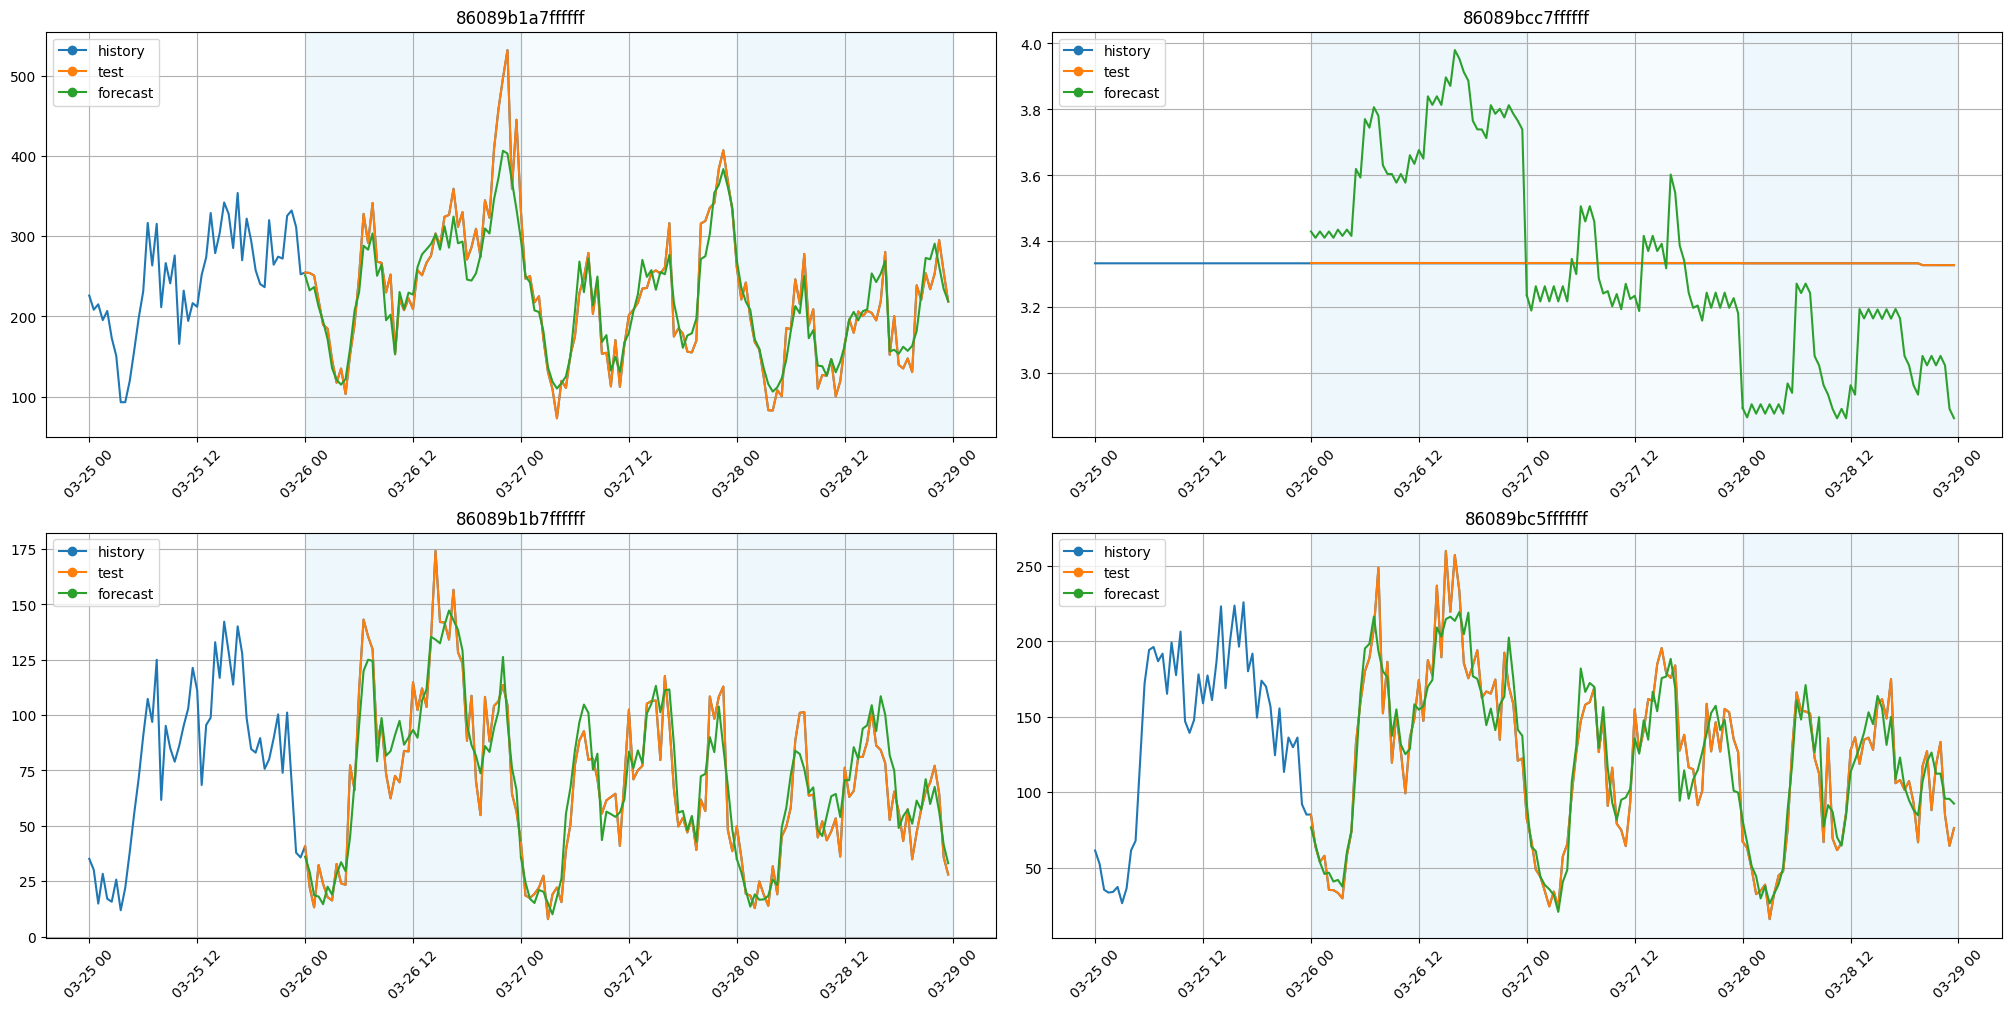

In [47]:
plot_backtest(result[1], ts, history_len=48, 
              segments=["86089b1a7ffffff", "86089bcc7ffffff", "86089b1b7ffffff", "86089bc5fffffff"]
             )

## Results

As I was able to show it is possible to predict areas of high value using the available data. The most promising model seems to be Boosting model with Uber H3 region clustering. This approach achieved `SMAPE < 9` on some regions (big regions). 
However futher work needs to be done such as:
- Agree on metric used to evaluate the perfomance of the model. SMAPE is not a fair metric for small regions.
- Agree on how in advance model will be used (in this work I simulated 1 day in advance)
- Rearrange the regions
- Collect more data on small regions
- Try ensemble of models to improve boosting baseline